In [1]:
# useful functions to print fit results on figure

def format_value(value, decimals):
    """ 
    Checks the type of a variable and formats it accordingly.
    Floats has 'decimals' number of decimals.
    """
    
    if isinstance(value, (float, np.float)):
        return f'{value:.{decimals}f}'
    elif isinstance(value, (int, np.integer)):
        return f'{value:d}'
    else:
        return f'{value}'

def values_to_string(values, decimals):
    """ 
    Loops over all elements of 'values' and returns list of strings
    with proper formating according to the function 'format_value'. 
    """
    
    res = []
    for value in values:
        if isinstance(value, list):
            tmp = [format_value(val, decimals) for val in value]
            res.append(f'{tmp[0]} +/- {tmp[1]}')
        else:
            res.append(format_value(value, decimals))
    return res


def len_of_longest_string(s):
    """ Returns the length of the longest string in a list of strings """
    return len(max(s, key=len))

def nice_string_output(d, extra_spacing=5, decimals=3):
    """ 
    Takes a dictionary d consisting of names and values to be properly formatted.
    Makes sure that the distance between the names and the values in the printed
    output has a minimum distance of 'extra_spacing'. One can change the number
    of decimals using the 'decimals' keyword.  
    """
    
    names = d.keys()
    max_names = len_of_longest_string(names)
    
    values = values_to_string(d.values(), decimals=decimals)
    max_values = len_of_longest_string(values)
    
    string = ""
    for name, value in zip(names, values):
        spacing = extra_spacing + max_values + max_names - len(name) - 1 
        string += "{name:s} {value:>{spacing}} \n".format(name=name, value=value, spacing=spacing)
    return string[:-2]

def add_text_to_ax(x_coord, y_coord, string, ax, fontsize=12, color='k'):
    """ Shortcut to add text to an ax with proper font. Relative coords."""
    ax.text(x_coord, y_coord, string, family='monospace', fontsize=fontsize,
            transform=ax.transAxes, verticalalignment='top', color=color)
    return None

def weighted_average_m1(distribution, weights):
      
    numerator = sum([distribution[i]*weights[i] for i in range(len(distribution))])
    denominator = sum(weights)
    
    return round(numerator/denominator,5)

In [2]:
class Chi2Regression:  # override the class with a better one
        
    def __init__(self, f, x, y, sy=None, weights=None, bound=None):
        
        if bound is not None:
            x = np.array(x)
            y = np.array(y)
            sy = np.array(sy)
            mask = (x >= bound[0]) & (x <= bound[1])
            x  = x[mask]
            y  = y[mask]
            sy = sy[mask]

        self.f = f  # model predicts y for given x
        self.x = np.array(x)
        self.y = np.array(y)
        
        self.sy = set_var_if_None(sy, self.x)
        self.weights = set_var_if_None(weights, self.x)
        self.func_code = make_func_code(describe(self.f)[1:])

    def __call__(self, *par):  # par are a variable number of model parameters
        
        # compute the function value
        f = compute_f(self.f, self.x, *par)
        
        # compute the chi2-value
        chi2 = np.sum(self.weights*(self.y - f)**2/self.sy**2)
        
        return chi2

In [3]:
import scipy as sp
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import find_peaks
from iminuit import Minuit

# Seaborn parameters
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

In [4]:
# Hook measurements (cm)
Lhook =2.68
d_Lhook = 0.02

# Ball measurements (cm)
ball = 6.05
d_ball = 0.05

# Pendulum lengths (cm)
# make the weighted mean
pend_lengths = np.array([157.2, 157.05, 157.1, 157.2])
pend_errors = np.array([0.1,0.2,0.1,0.2])
mean_length = np.mean(pend_lengths)
RMS_pend_length = np.std(pend_lengths)
Wmean = weighted_average_m1(pend_lengths,pend_errors)
print(f'The pendulum mean length is {mean_length:5.4f}')
print(f'The pendulum Weighted mean length is {Wmean:5.3f}')
print(f'The pendulum RMS length is {RMS_pend_length:5.3f}')
#Pendulum period of swing
t1 = 'https://raw.githubusercontent.com/BoubisTheCoder/Troelo_Team_Stat/main/data_pendulum/pend_e.txt'
t2 = 'https://raw.githubusercontent.com/BoubisTheCoder/Troelo_Team_Stat/main/data_pendulum/pend_f.txt'
t3 = 'https://raw.githubusercontent.com/BoubisTheCoder/Troelo_Team_Stat/main/data_pendulum/pend_m.txt'
t4 = 'https://raw.githubusercontent.com/BoubisTheCoder/Troelo_Team_Stat/main/data_pendulum/pend_n2.txt'

# defining variables in pendulum period measurements
def read_data(filename):
    dat = np.genfromtxt(filename, delimiter='\t', names=('n', 't_s'))
    return dat

data1 = read_data(t1)
data2 = read_data(t2)
data3 = read_data(t3)
data4 = read_data(t4)

n1, t_s1 = data1['n'], data1['t_s']
n2, t_s2 = data2['n'], data2['t_s']
n3, t_s3 = data3['n'], data3['t_s']
n4, t_s4 = data4['n'], data4['t_s']

The pendulum mean length is 157.1375
The pendulum Weighted mean length is 157.133
The pendulum RMS length is 0.065


In [5]:
# Define a fit function:
def fit_function(x, alpha0, alpha1):
    return alpha0 + alpha1*x

# Testing with n1,t_s1
x= n1
y = t_s1
sigmay = 0.1 #uncertainity on each point
ey = sigmay*np.ones_like(x)

print(len(y))
# Read data file and print to check
# produce the std for time and introduce std as the error in chi2
print("Just to check. Number of entries: ", len(x))
for i in range(5) : 
   print(f"{int(x[i]):2d}{y[i]:10.2f}")


# Alternatively, you can define Chi2 calculation:
def chi2_owncalc(alpha0, alpha1) :
    y_fit = fit_function(x, alpha0, alpha1)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_owncalc.errordef=   1    # Chi2 definition (for Minuit)

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_owncalc, alpha0=3.0, alpha1=0.0)     # Own alternative
print(minuit)
# Perform the actual fit:
minuit.migrad();

# Extract the fitting parameters and their errors:
alpha0_fit = minuit.values['alpha0']
alpha1_fit = minuit.values['alpha1']
sigma_alpha0_fit = minuit.errors['alpha0']
sigma_alpha1_fit = minuit.errors['alpha1']

  
Nvar = 2                     # Number of variables (alpha0 and alpha1)
Ndof_fit = len(x) - minuit.nfit   # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

# Let us see what the fit gives for the first couple of data sets:
print(f"  Fit: a0={alpha0_fit:6.3f}+-{sigma_alpha0_fit:5.3f}  a1={alpha1_fit:5.3f}+-{sigma_alpha1_fit:5.3f}  p={Prob_fit:6.4f}")

#residuals calculation
residuals = y- fit_function(x, *minuit.values)

print(residuals)

28
Just to check. Number of entries:  28
 5     15.70
 6     18.15
 7     20.74
 8     23.19
 9     25.69
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha0 │   3.00    │   0.03    │            │            │         │         │       │
│ 1 │ alpha1 │    0.0    │    0.1    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
  Fit: a0= 3.114+-0.047  a1=2.511+-0.002  p=0.9917
[ 0.02922291 -0.03123355  0.04310999 -0.01754647 -0.02270293  0.13154061
  0.00668415 -0.0693723  -0.05692876  0.06411478 -0.04374168 -0.02439814
  0.1644454  -0.03431106 -0.17456752  0.03587603 -0.01728043  0.01776311
 -0.02759335 -0.00894981 -0.03010627 -0.09046273 -0.02251918  0.02

<ipython-input-1-18297b4810b0>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(value, (float, np.float)):


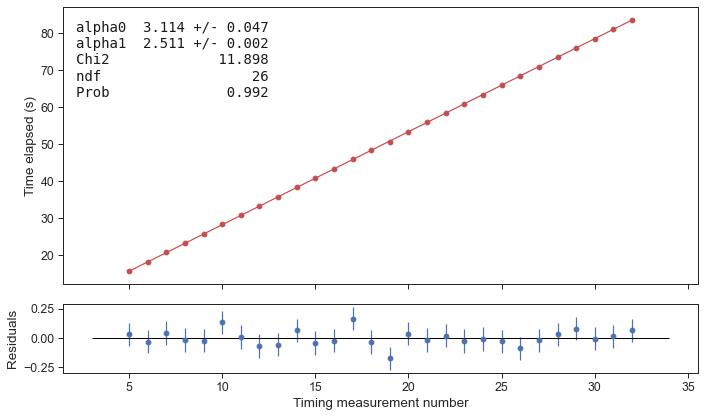

In [6]:
#Plotting
save_plots = False



fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6),
                      gridspec_kw={'height_ratios':[4,1]}, sharex=True)
ax[0].errorbar(x, y, ey, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
ax[0].plot(x, fit_function(x, *minuit.values[:]), '-r')
ax[0].set_ylabel('Time elapsed (s)')

ax[1].errorbar(x,residuals, ey, color='b', fmt='o')
ax[1].hlines(y=0, xmin=3, xmax=34, linewidth=1, color='black')   #annotation: line with y=0
ax[1].set_xlabel('Timing measurement number')
ax[1].set_ylabel('Residuals')
#ax[1].set_xlim([3,40])

#ax3 = fig.add_axes([0.7, 0.65, 0.2, 0.2])
plt.close()

d = {'alpha0':   [alpha0_fit, sigma_alpha0_fit],
     'alpha1':   [alpha1_fit, sigma_alpha1_fit],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }


text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax[0], fontsize=14)
fig.tight_layout()
if (save_plots) :
    fig.savefig("FitToLine.pdf")
fig

In [8]:
# ploting
#fig2, ax2 = plt.subplots(figsize=(14, 8))
#ax2.errorbar(x, y, yerr=sy, xerr=0.025, label='Distribution of time residuals', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
#ax2.set(xlim=(xmin, xmax), ylim=(0, 1.2*np.max(y)), xlabel='Time Residuals', ylabel='Frequency');

# Create the x-axis for the plot of the fitted function, and compute the fitted function for x_fit:
#xaxis = np.linspace(xmin, xmax, 1000) 
#yaxis = gauss_pdf(xaxis, *minuit_gaussian.values[:])
#print(minuit_gaussian.values[:])

#plotting
#ax2.plot(xaxis, yaxis, '-', label=f'Gaussian fit: p(Chi2={Chi2_gau:.1f},Ndof={Ndof_gau:d}) = {Prob_gau:.3f}')
#ax2.legend()

#fig2.tight_layout()
#fig2

#fig2.savefig('tt.png')


#ax2 = plt.axes()  # standard axes
#ax3 = plt.axes([0.65, 0.65, 0.2, 0.2])
#ax3 = plt.axes(ax2)

In [9]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [111]:
###   Use your residual data and fit a gaussian distribution with chi2 ####


# Define a gaussian PDF:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)



#initial values for the fit
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
ey2 = np.sqrt((len(residuals)))


#binned data for the gaussian fit
Nbins = 26
xmin = -0.4
xmax = 0.4
binwidth = (xmax-xmin)/Nbins
print(binwidth)

# ... or... create a scatter plots with the frequency of your data residuals  ....

counts, bin_edges = np.histogram(residuals, bins=Nbins, range=(-0.5, 0.5))
print(counts)
print(bin_edges)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)                         # NOTE: We (naturally) assume that the bin count is Poisson distributed.

# We remove any bins, which don't have any counts in them (for Chi2 fitting):
x2 = bin_centers[counts>0]
print(x2)
y2 = counts[counts>0]
sy2 = s_counts[counts>0]


#chi2 for the binned data using minuit
chi2_gauss = Chi2Regression(gauss_pdf, x2, y2, sy2)
chi2_gauss.errordef = 1
minuit_gaussian = Minuit(chi2_gauss, mu= mean_residuals, sigma = std_residuals) #   

minuit_gaussian.migrad();           # Perform the actual fit (without printing)
Chi2_gau = minuit_gaussian.fval
Ndof_gau = len(x2) - 2              # 2 parameters in fit
Prob_gau = stats.chi2.sf(Chi2_gau, Ndof_gau)







0.03076923076923077
[ 0  0  0  0  0  0  0  0  1  0  1  3 11  6  3  1  1  1  0  0  0  0  0  0
  0  0]
[-0.5        -0.46153846 -0.42307692 -0.38461538 -0.34615385 -0.30769231
 -0.26923077 -0.23076923 -0.19230769 -0.15384615 -0.11538462 -0.07692308
 -0.03846154  0.          0.03846154  0.07692308  0.11538462  0.15384615
  0.19230769  0.23076923  0.26923077  0.30769231  0.34615385  0.38461538
  0.42307692  0.46153846  0.5       ]
[-0.17307692 -0.09615385 -0.05769231 -0.01923077  0.01923077  0.05769231
  0.09615385  0.13461538  0.17307692]


<ipython-input-130-125cc34761c5>:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


[0.04491498632364202]


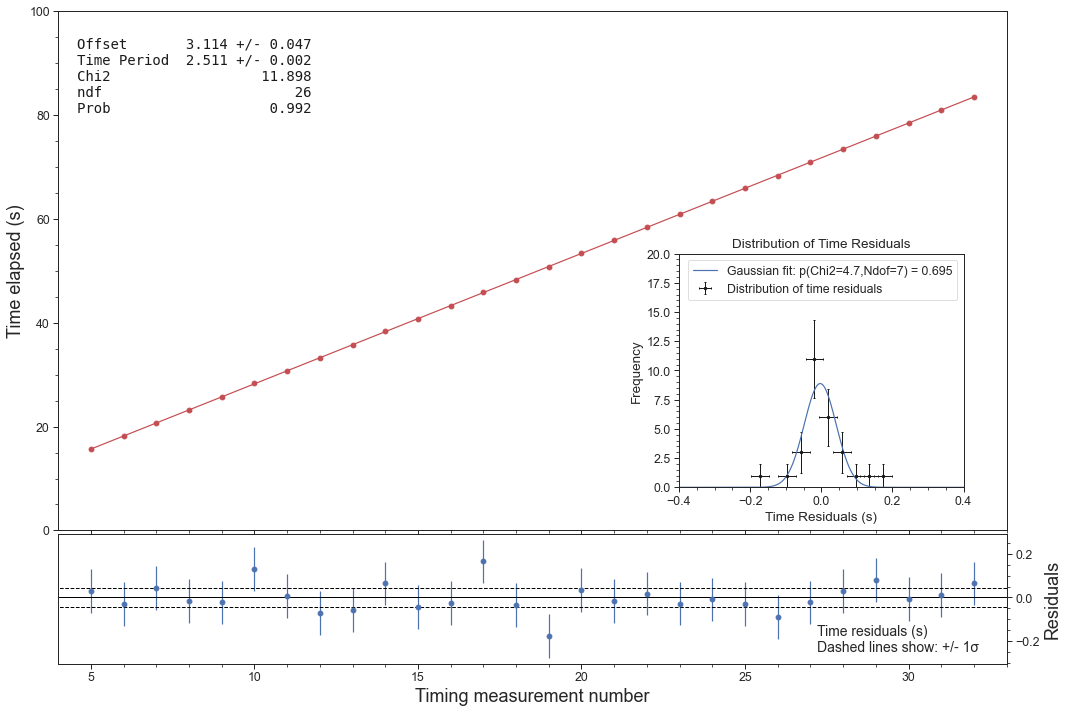

In [130]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator
minor_locator = AutoMinorLocator(6)


spec = gridspec.GridSpec(ncols=1, nrows=2,
                         width_ratios=[1], 
                         hspace=0.01, height_ratios=[4, 1])


fig = plt.figure(figsize=[17, 12])
# set height of each subplot as 8
#fig.set_figheight(8)
 
# set width of each subplot as 8
#fig.set_figwidth(8)


#gs = fig.add_gridspec(2,1 , width_ratios=[1,4])
#ax = fig.add_subplot(211)
#ax = fig.add_subplot(2,1,1, adjustable='box', aspect=0.1)
#gs = gridspec.GridSpec(2, 1, width_ratios=[3, 1]) 

#plot the time values................................
ax = fig.add_subplot(spec[0])


ax.plot(x, fit_function(x, *minuit.values[:]), '-r')
ax.errorbar(x, y, ey, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
ax.set_ylabel('Time elapsed (s)', fontsize=18)
ax.set_ylim([0,100])
ax.set_xlim([4,33])
ax.minorticks_on()

#plot the residuals........................

#ax2 = fig.add_subplot(212)
ax2 = fig.add_subplot(spec[1])

ax2.errorbar(x,residuals, ey, color='b', fmt='o')
ax2.hlines(y=0, xmin=0, xmax=33, linewidth=1, color='black')   #annotation: line with y=0
ax2.hlines(y=0.045, xmin=0, xmax=33, linestyles='--', linewidth=1, color='black')   #annotation: line with y=0
ax2.hlines(y=-0.045, xmin=0, xmax=33,linestyles='--',  linewidth=1, color='black')   #annotation: line with y=0
ax2.set_xlabel('Timing measurement number', fontsize=18)
ax2.set_ylabel('Residuals', fontsize=18)
ax2.minorticks_on()
ax2.yaxis.set_tick_params(which='minor', left=False, right=True)
ax2.tick_params(left=False, right=True, labelleft=False, labelright=True)
ax2.set_xlim([4,33])
ax2.yaxis.set_label_position("right")

#add text

textstr = '\n'.join((
     "Time residuals (s)", 
    "Dashed lines show: +/- 1σ"))

ax2.text(0.8, 0.3, textstr, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top')





plt.close()

d = {'Offset':   [alpha0_fit, sigma_alpha0_fit],
     'Time Period':   [alpha1_fit, sigma_alpha1_fit],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }


text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=14)
fig.tight_layout()
if (save_plots) :
    fig.savefig("FitToLine.pdf")
fig


# Create an inset outside the axes for the gaussian fit of the binned data .........

axins = inset_axes(ax, width="30%", height="45%", loc=4, borderpad=3.5)
axins.set_position([0.2, 0.2,1, 0.2])
axins.minorticks_on()

axins.tick_params(left=True, right=False, labelleft=True, labelright=False)

axins.errorbar(x2, y2, yerr=sy2, xerr=0.025, label='Distribution of time residuals', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
axins.set(xlim=(xmin, xmax), ylim=(0, 1.2*np.max(y)), xlabel='Time Residuals (s)', ylabel='Frequency');
axins.set_title("Distribution of Time Residuals")

# Create the x-axis for the plot of the fitted function, and compute the fitted function for x_fit:
xaxis = np.linspace(xmin, xmax, 1000) 
yaxis = gauss_pdf(xaxis, *minuit_gaussian.values[:])
print(minuit_gaussian.values[1,])

#plotting
axins.plot(xaxis, yaxis, '-', label=f'Gaussian fit: p(Chi2={Chi2_gau:.1f},Ndof={Ndof_gau:d}) = {Prob_gau:.3f}')
axins.legend()
axins.set_ylim([0,20])


# overall plot
fig